In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200
import matplotlib.colors as colors
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import numpy.linalg as la
from sklearn.metrics import r2_score
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import StepLR
from pathlib import Path

In [2]:
def to_np(tens):
    return tens.detach().cpu().numpy()

In [3]:
def filter_indices_with_lags(train_data_index, num_lags):
    train_indices = []
    val_indices = []
    # Iterate through the train_data_index with a buffer zone of num_lags
    for i in range(len(train_data_index) - num_lags):
        # Check if the current index and all the next num_lags indices are the same
        if all(train_data_index[i + j] == 1 for j in range(num_lags + 1)):
            train_indices.append(i)
        elif all(train_data_index[i + j] == 0 for j in range(num_lags + 1)):
            val_indices.append(i)
    
    return train_indices, val_indices

def split_dataset(dataset, train_data_index, num_lags):
    train_indices, val_indices = filter_indices_with_lags(train_data_index, num_lags)
    
    # Create subsets for training and validation
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    return train_subset, val_subset

In [4]:
def low_rank_svd_components_approximation(A, r):
    # Perform Singular Value Decomposition
    A_r = A - np.diag(np.diag(A))
    U, s, Vt = np.linalg.svd(A_r, full_matrices=False)
    # Keep only the top r singular values (and corresponding vectors)
    Ur = U[:, :r]
    Sr = np.diag(s[:r])  # Create a diagonal matrix of the top r singular values
    Vtr = Vt[:r, :]
    # Reconstruct the low-rank approximation of the matrix
    Ar = np.dot(Ur, np.dot(Sr, Vtr))
    return np.diag(A), Ur, np.dot(Sr, Vtr).T, Ar

In [5]:
def diag_off_diag_extraction(A):
    # Perform Singular Value Decomposition
    A_r = A - np.diag(np.diag(A))
    return np.diag(A), A_r

In [6]:
def compute_transfer_matrix(Ahat):
    k = 4
    avg_connect_ark = np.zeros((d,d))
    rollout_len = 1000
    params = []
    A_params = []
    B_params = []
    for i in range(k):
        params.append(np.zeros((d,d)))
        A_params.insert(0,Ahat[:,i*d:(i+1)*d])
        B_params.insert(0,Ahat[:,d*k+i*d:d*k+(i+1)*d])

    for t in range(rollout_len):
        param_new = np.zeros((d,d))
        for i in range(k):
            param_new += A_params[i] @ params[i]
        if t <= k-1:
            param_new += B_params[t]
        params = params[:-1]
        params.insert(0,param_new)
        avg_connect_ark += params[0]
    return avg_connect_ark

In [7]:
def plot_rank_svd(A):
    A2 = A - np.diag(np.diag(A))
    U_true,S_true,V_true = la.svd(A2)
    plt.plot(S_true,label='minus diag')

    U_true,S_true,V_true = la.svd(A)
    plt.plot(S_true,label='full')
    plt.legend()
    plt.show()
    # print(S_true)

In [8]:
def compute_transfer_matrix(Ahat):
    k = 4
    avg_connect_ark = np.zeros((d,d))
    rollout_len = 1000
    params = []
    A_params = []
    B_params = []
    for i in range(k):
        params.append(np.zeros((d,d)))
        A_params.insert(0,Ahat[:,i*d:(i+1)*d])
        B_params.insert(0,Ahat[:,d*k+i*d:d*k+(i+1)*d])

    for t in range(rollout_len):
        param_new = np.zeros((d,d))
        for i in range(k):
            param_new += A_params[i] @ params[i]
        if t <= k-1:
            param_new += B_params[t]
        params = params[:-1]
        params.insert(0,param_new)
        avg_connect_ark += params[0]
    return avg_connect_ark

In [9]:
# linear model + torch gradient descent
class TimeseriesDataset(Dataset):
    def __init__(self, X, U, num_lags):
        self.X = X
        self.U = U
        self.num_lags = num_lags

    def __len__(self):
        # The dataset length is reduced by num_lags due to the dependency on previous data points
        return len(self.X) - self.num_lags

    def __getitem__(self, index):
        # Return slices for X and U for the current index adjusted for lags
        X_history = [self.X[index + i] for i in range(self.num_lags)]
        U_history = [self.U[index + i] for i in range(self.num_lags)]
        X_next = self.X[index + self.num_lags]
        return X_history, U_history, X_next
    
def spectral_projection(matrix):
    # Assuming matrix is square and differentiable
    eigenvalues, eigenvectors = torch.linalg.eig(matrix)
    # Clip the eigenvalues
    clipped_eigenvalues = torch.clamp(eigenvalues.real, max=1)  # only take the real parts, assuming eigenvalues are real
    # Reconstruct the matrix with the modified eigenvalues
    diagonal_matrix = torch.diag(torch.complex(clipped_eigenvalues, torch.zeros_like(clipped_eigenvalues)))
    projected_matrix = eigenvectors @ diagonal_matrix @ eigenvectors.inverse()
    return projected_matrix.real  # assuming the input matrix is real

def singular_value_norm(matrix):
    norm_val = torch.linalg.norm(matrix, 2)
    if norm_val > 2: 
        matrix = 2 * matrix / norm_val
    return matrix

class LinearDynamicModel(nn.Module):
    def __init__(self, state_dim, input_dim, num_lags, init_value = None):
        
        super(LinearDynamicModel, self).__init__()
        
        if init_value is None:
            # Create diagonal matrices for alpha and beta, one for each lag
            self.alpha = nn.ParameterList([nn.Parameter(torch.randn(state_dim)) for _ in range(num_lags)])
            self.beta = nn.ParameterList([nn.Parameter(torch.randn(state_dim)) for _ in range(num_lags)])

            self.W = nn.ParameterList([nn.Parameter(torch.randn(state_dim, state_dim)) for _ in range(num_lags)])
            self.B = nn.ParameterList([nn.Parameter(torch.randn(state_dim, input_dim)) for _ in range(num_lags)])

            self.V = nn.Parameter(torch.randn(state_dim))
        else:
            # Create diagonal matrices for alpha and beta, one for each lag
            self.alpha = nn.ParameterList([nn.Parameter(init_value['alpha'][i]) for i in range(num_lags)])
            self.beta = nn.ParameterList([nn.Parameter(init_value['beta'][i]) for i in range(num_lags)])

            self.W = nn.ParameterList([nn.Parameter(init_value['W'][i]) for i in range(num_lags)])
            self.B = nn.ParameterList([nn.Parameter(init_value['B'][i]) for _ in range(num_lags)])

            self.V = nn.Parameter(init_value['V'])
        
    def forward(self, X_history, U_history):
        X_next = torch.zeros_like(X_history[0])
        for W_k, alpha_k, X_k in zip(self.W, self.alpha, X_history):
            # X_k has shape (batch_size, state_dim)
            # Apply W_k to each batch element using batch matrix multiplication
            X_k = X_k.unsqueeze(-1)  # Shape becomes (batch_size, state_dim, 1)
            alpha_diag_k = torch.diag(alpha_k)
            contribution = torch.matmul(singular_value_norm(W_k + alpha_diag_k), X_k).squeeze(-1)  # Shape returns to (batch_size, state_dim)
            X_next += contribution
        for B_k, beta_k, U_k in zip(self.B, self.beta, U_history):
            U_k = U_k.unsqueeze(-1)
            beta_diag_k = torch.diag(beta_k)
            contribution = torch.matmul(singular_value_norm(B_k + beta_diag_k), U_k).squeeze(-1)
            X_next += contribution
        X_next += self.V[None, :]
        return X_next
    
class LowRankLinearDynamicModel(nn.Module):
    def __init__(self, state_dim, input_dim, rank_dim, num_lags, init_value = None):
        super(LowRankLinearDynamicModel, self).__init__()
        
        if init_value is None:
            # Create diagonal matrices for alpha and beta, one for each lag
            self.alpha = nn.ParameterList([nn.Parameter(torch.randn(state_dim)) for _ in range(num_lags)])
            self.beta = nn.ParameterList([nn.Parameter(torch.randn(state_dim)) for _ in range(num_lags)])

            self.W_u = nn.ParameterList([nn.Parameter(torch.randn(state_dim, rank_dim)) for _ in range(num_lags)])
            self.W_v = nn.ParameterList([nn.Parameter(torch.randn(state_dim, rank_dim)) for _ in range(num_lags)])

            self.B_u = nn.ParameterList([nn.Parameter(torch.randn(state_dim, rank_dim)) for _ in range(num_lags)])
            self.B_v = nn.ParameterList([nn.Parameter(torch.randn(state_dim, rank_dim)) for _ in range(num_lags)])

            self.V = nn.Parameter(torch.randn(state_dim))
        else:
            # Create diagonal matrices for alpha and beta, one for each lag
            self.alpha = nn.ParameterList([nn.Parameter(init_value['alpha'][i]) for i in range(num_lags)])
            self.beta = nn.ParameterList([nn.Parameter(init_value['beta'][i]) for i in range(num_lags)])

            self.W_u = nn.ParameterList([nn.Parameter(init_value['W_u'][i]) for i in range(num_lags)])
            self.W_v = nn.ParameterList([nn.Parameter(init_value['W_v'][i]) for i in range(num_lags)])

            self.B_u = nn.ParameterList([nn.Parameter(init_value['B_u'][i]) for _ in range(num_lags)])
            self.B_v = nn.ParameterList([nn.Parameter(init_value['B_v'][i]) for _ in range(num_lags)])

            self.V = nn.Parameter(init_value['V'])
        
    def forward(self, X_history, U_history):
        X_next = torch.zeros_like(X_history[0])
        for W_u_k, W_v_k, alpha_k, X_k in zip(self.W_u, self.W_v, self.alpha, X_history):
            # X_k has shape (batch_size, state_dim)
            # Apply W_k to each batch element using batch matrix multiplication
            X_k = X_k.unsqueeze(-1)  # Shape becomes (batch_size, state_dim, 1)
            alpha_diag_k = torch.diag(alpha_k)
            W_k = torch.mm(W_u_k, W_v_k.T)
            contribution = torch.matmul(singular_value_norm(W_k + alpha_diag_k), X_k).squeeze(-1)  # Shape returns to (batch_size, state_dim)
            X_next += contribution
        for B_u_k, B_v_k, beta_k, U_k in zip(self.B_u, self.B_v, self.beta, U_history):
            U_k = U_k.unsqueeze(-1)
            beta_diag_k = torch.diag(beta_k)
            B_k = torch.mm(B_u_k, B_v_k.T)
            contribution = torch.matmul(singular_value_norm(B_k + beta_diag_k), U_k).squeeze(-1)
            X_next += contribution
        X_next += self.V[None, :]
        return X_next

def train_model(model, train_loader, val_loader, epochs=100, lr=0.01, clip_value=1.0, l1_lambda=0.01, step_size=50, gamma=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)  # Learning rate scheduler
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    
    # Lists to track loss
    train_losses = []
    val_losses = []
    l1_penalty_losses = []
    
    current_lr = lr

    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        total_l1_penaty = 0

        for X_history, U_history, X_next in train_loader:
            optimizer.zero_grad()
            predictions = model(X_history, U_history)
            loss = criterion(predictions, X_next)
            
            total_train_loss += loss.item()
            
            # Compute the L1 penalty for each parameter
            l1_penalty = torch.tensor(0.).to(device)
            
            '''
            for param in model.W:
                l1_penalty += torch.norm(param,1)
            for param in model.B:
                l1_penalty += torch.norm(param,1)
            for param in model.alpha:
                l1_penalty += torch.norm(param,1)
            for param in model.beta:
                l1_penalty += torch.norm(param,1)
            '''
            
            # Add the L1 penalty to the original loss
            loss += l1_lambda * l1_penalty
            
            total_l1_penaty += l1_penalty.item()
            
            loss.backward()
            optimizer.step()
            
            # Apply gradient clipping
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        # scheduler.step()  # Update the learning rate
        # current_lr = scheduler.get_last_lr()[0]  # Get the last learning rate
        
        # Validation Phase
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for X_history, U_history, X_next in val_loader:
                predictions = model(X_history, U_history)
                loss = criterion(predictions, X_next)
                total_val_loss += loss.item()

        # Logging training and validation loss
        train_loss = total_train_loss / len(train_loader)
        val_loss = total_val_loss / len(val_loader)
        l1_penaty_loss = total_l1_penaty / len(train_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        l1_penalty_losses.append(l1_penaty_loss)
        
        print(f'Epoch {epoch}: Train Loss = {train_loss}, Val Loss = {val_loss}, L1 Penalty Loss = {l1_penaty_loss}, LR = {current_lr}')

        # Checkpointing based on minimal validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            Path("checkpoints").mkdir(exist_ok=True)
            checkpoint_path = f'checkpoints/model_best_test.pt'
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch} with Val Loss: {val_loss:.4f}")
            
    # Plotting the training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plotting the L1 penalties
    plt.figure(figsize=(10, 5))
    plt.plot(l1_penalty_losses, label='L1 Penalty', color='red')
    plt.title('L1 Penalty Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('L1 Penalty')
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
# trial data
data = np.load('../data/andrew/sample_photostim_0113.npy', allow_pickle = True).item()
y = data['y']
u = data['u']
num_trials = y.shape[0]
num_steps = y.shape[1]
num_neurons = y.shape[2]
T_before = 4
T_after_start = 9
T_after_end = 13
y_before = np.mean(y[:,:T_before,:],axis = 1)
y_after = np.mean(y[:,T_after_start:T_after_end,:],axis = 1)

y_session = data['y_session']
u_session = data['u_session']

# linear interpolation of data
y_session_interp = y_session.copy()
for i in range(y_session.shape[1]):
    nan_start = -1
    nan_stop = -1
    for j in range(y_session.shape[0]):
        if nan_start == -1 and np.isnan(y_session_interp[j,i]):
            nan_start = j - 1
        if nan_start != -1 and not np.isnan(y_session_interp[j,i]):
            nan_stop = j
        if nan_start != -1 and nan_stop != -1:
            slope = y_session_interp[nan_stop,i] - y_session_interp[nan_start,i]
            for k in range(nan_stop - nan_start - 1):
                y_session_interp[nan_start + k + 1,i] = slope*k/(nan_stop-nan_start-1) + y_session_interp[nan_start,i]
            nan_start = -1
            nan_stop = -1
            
# y_session = y_session[4:,:]
# u_session = u_session[4:,:]
# y_session_interp = y_session_interp[4:,:]

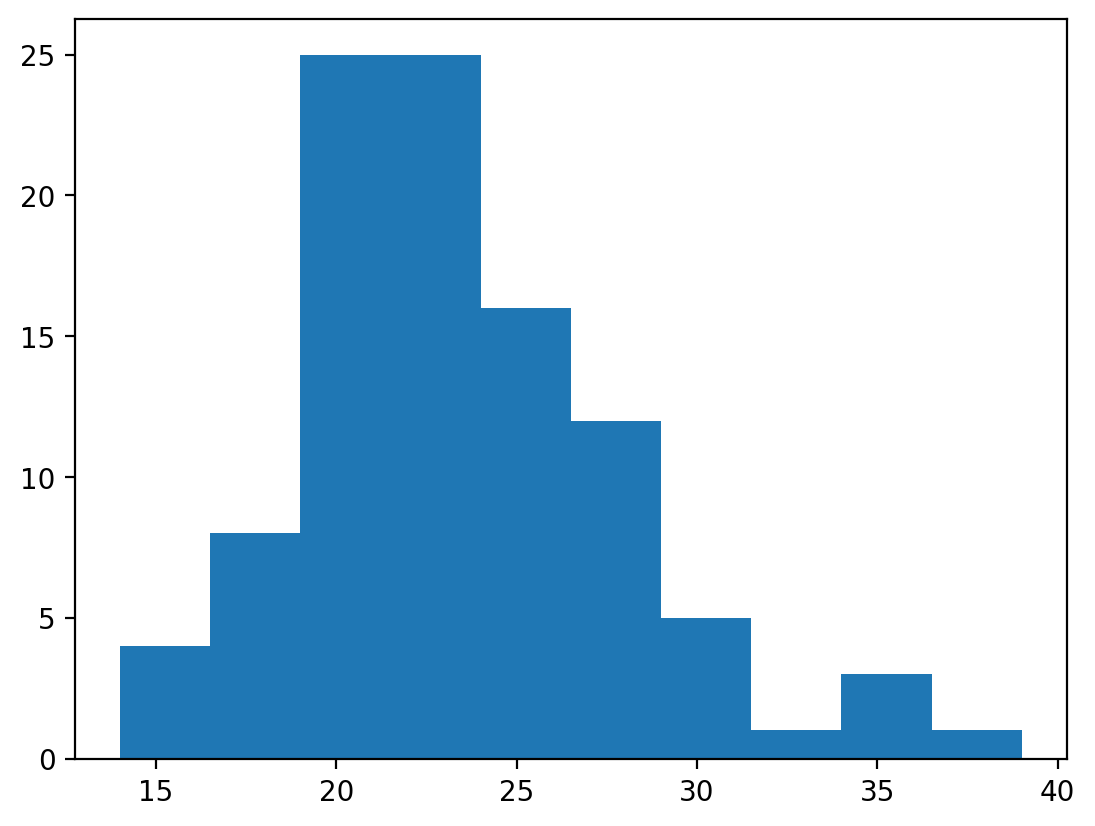

In [11]:
patterns = []
pattern_count = []
pattern_idx = []
pattern_length = []

start = -10
for t in range(u_session.shape[0]):
    if np.sum(np.abs(u_session[t,:])) > 0 and t > start + 4:
        idx = np.linspace(0,663-1,663).astype(int)
        on = u_session[t,:] > 0
        pattern = np.array(idx[on])
        start = t
        found = False
        for i in range(len(patterns)):
            if len(pattern) == len(patterns[i]):
                if np.linalg.norm(pattern - patterns[i]) == 0:
                    pattern_count[i] += 1
                    pattern_idx[i].append(t)
                    found = True
                    break
        if found is False:
            patterns.append(pattern)
            pattern_count.append(1)
            pattern_idx.append([t])
            pattern_length.append(len(pattern))

neuron_pattern = np.zeros(663)
for i in range(663):
    for p in patterns:
        if i in p:
            neuron_pattern[i] += 1

plt.hist(pattern_count)
plt.show()

pattern id: 44
pattern id: 47
pattern id: 64
pattern id: 67
pattern id: 67
pattern id: 9
113 0.21980532969315686
5


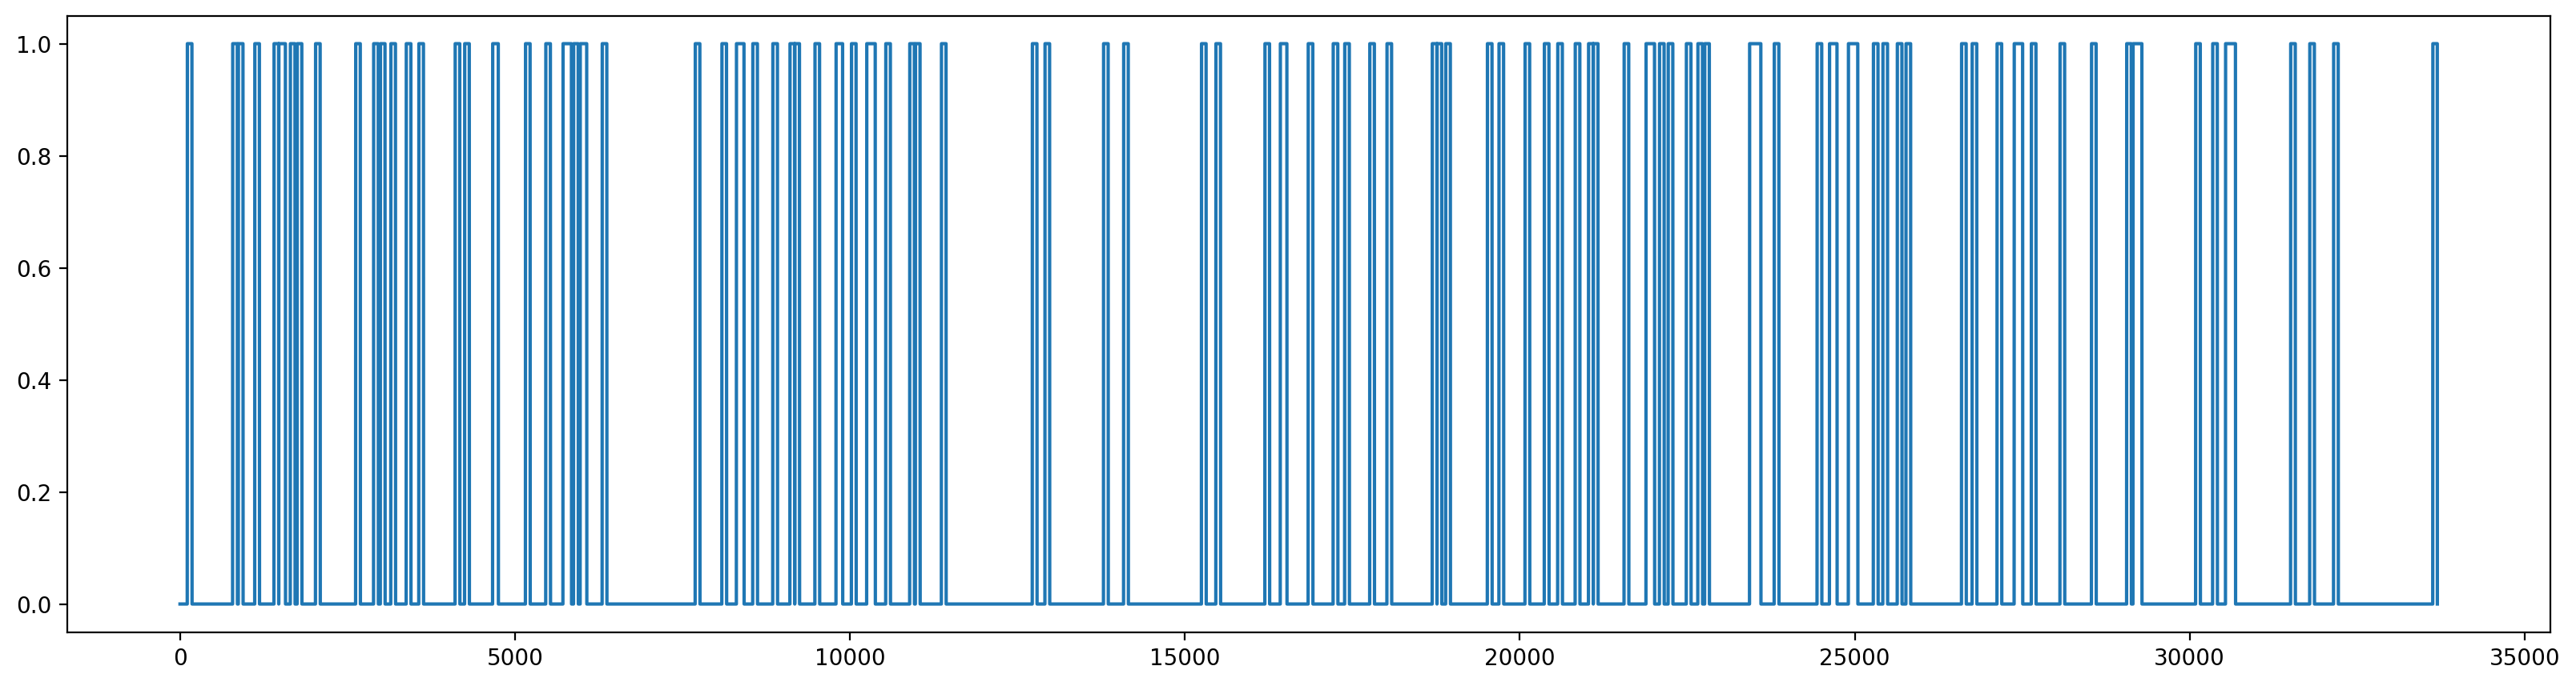

In [12]:
# remove patterns randomly

num_patterns = 5
removed_patterns = []
removed_neurons = []
removed_steps = np.zeros(u_session.shape[0])
removed_count = 0

np.random.seed(0)
while len(removed_patterns) < num_patterns:
    p_idx = np.random.randint(0,len(patterns))
    print('pattern id:', p_idx)
    if p_idx not in removed_patterns:
        removed_patterns.append(p_idx)
        removed_count += pattern_count[p_idx]
        removed_neurons.extend(patterns[p_idx])
        for i in pattern_idx[p_idx]:
            min_idx = np.max([0,i-20])
            max_idx = np.min([i+50,u_session.shape[0]-1])
            removed_steps[min_idx:max_idx] = 1
            
                
print(removed_count, np.sum(removed_steps) / u_session.shape[0])
print(len(removed_patterns))
plt.figure(figsize=(20,5))
plt.plot(removed_steps)
plt.show()

test_indices = removed_steps.astype(int)
train_indices = np.ones(test_indices.shape[0]).astype(int) - test_indices.copy()
removed_neurons = list(set(removed_neurons))

train_test_split = {}
train_test_split['train_indices'] = train_indices
train_test_split['test_indices'] = test_indices
# np.save('train_test_split',train_test_split)

In [13]:
removed_pattern_ids = [44, 47, 64, 67, 9]
check_neuron_id = removed_neurons[3] #0
check_neuron_id = removed_neurons[6] #0
check_neuron_id = removed_neurons[29] #1
check_neuron_id = removed_neurons[52] #0
count = 0
for pattern_id in range(len(patterns)):
    if pattern_id not in removed_pattern_ids:
        if check_neuron_id in patterns[pattern_id]:
            count += 1
print(count)

0


In [14]:
spiking = np.zeros(u_session.shape).astype(bool)

for neuron in range(u_session.shape[1]):
    output_true = y_session_interp[4:,neuron]
    mean_threshold = np.median(output_true)
    lower_tail_idx = (output_true < mean_threshold)
    lower_tail_data = output_true[lower_tail_idx]
    lower_tail_std = np.std(lower_tail_data)
    print(lower_tail_std)
    true_spike_threshold = mean_threshold + 6*lower_tail_std
    true_spikes = (output_true > true_spike_threshold)
    spiking[4:,neuron] = true_spikes  
    
#np.save('spiking_labels',spiking)

10.926305
6.8637924
10.2582035
8.80526
9.282541
10.277796
19.47125
8.010129
6.368451
12.515049
8.127925
7.872719
9.254664
9.460864
6.900674
6.7014256
13.435938
13.280504
5.815727
5.553677
7.1259336
7.792279
13.807764
8.649218
10.296269
10.225375
10.375469
13.5954075
10.399429
7.4910517
6.2267127
6.7933927
9.528945
6.36728
10.152898
5.5899534
11.161926
8.639719
4.9650493
6.7699227
7.3379025
9.040896
7.3271065
11.73246
13.986362
9.226959
8.180463
5.7991967
9.400248
13.124448
11.497623
5.844215
10.059646
9.304157
9.6105795
5.063303
7.6047525
6.7856374
7.1048026
10.863687
8.672426
12.873427
5.566862
9.275431
11.061833
6.51319
8.993106
5.0163984
5.834947
9.683207
7.2687974
11.5129175
11.0101385
9.233922
10.026835
11.600518
9.963518
11.38672
7.4664526
10.166133
9.710266
9.179704
15.667917
5.734885
7.3031383
8.293233
14.334215
7.272676
8.916961
10.608227
11.324754
11.225982
7.0736065
10.678194
11.547289
9.894718
8.6037245
10.13237
7.8902493
13.090778
5.7624125
13.112546
8.051336
8.795618
8.71

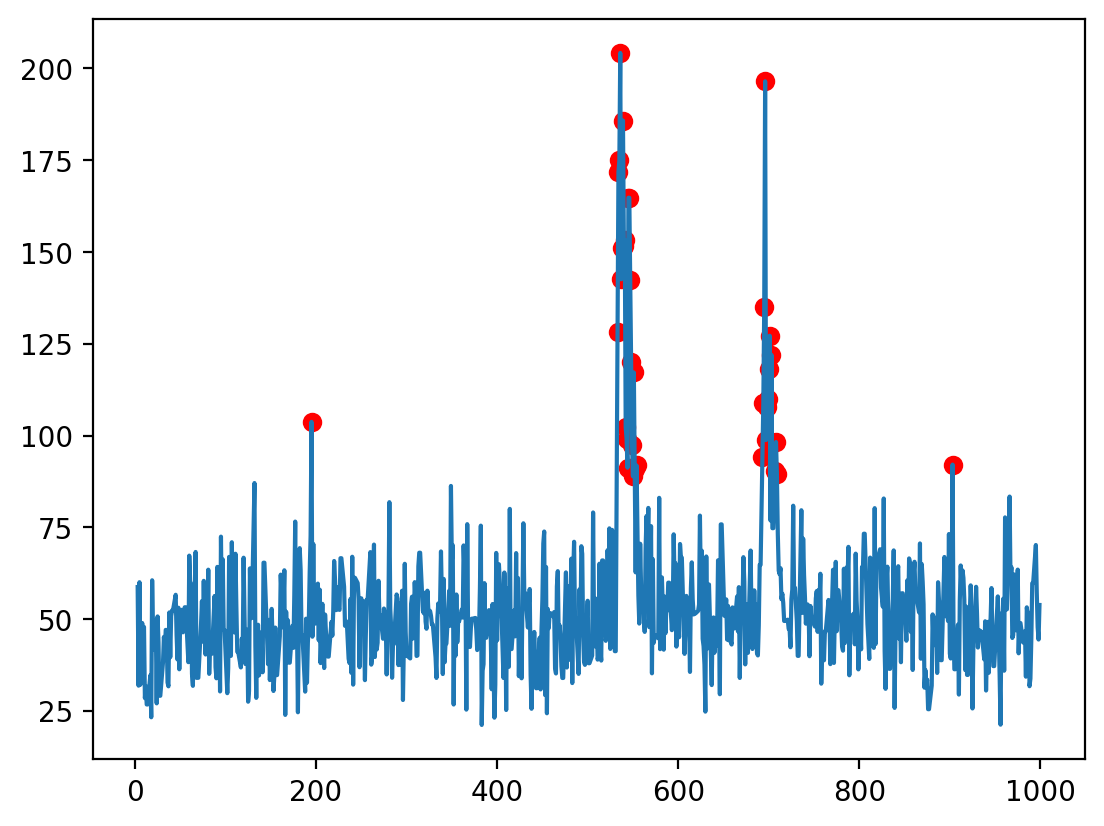

In [15]:
neuron = 206
T = 1000
plt.plot(y_session_interp[:T,neuron])
idx = np.linspace(0,T-1,T)
spiking_neuron = spiking[:T,neuron]
y_out = y_session_interp[0:T,neuron].copy()
y_out = y_out * spiking_neuron
y_out[y_out == 0] = np.nan
plt.scatter(idx,y_out,color='r')  
plt.show()

In [16]:
normalize = 1000
# linear model + closed form
ark_order = 4
X = []
Xp = []
for t in range(train_indices.shape[0]-ark_order):
    if np.sum(train_indices[t:t+ark_order+1]) == ark_order + 1 and t > 5 + ark_order:
        X.append(np.concatenate((y_session_interp[t:t+ark_order,:].copy().flatten()/normalize, u_session[t:t+ark_order,:].copy().flatten(),np.ones(1)))) 
        Xp.append(y_session_interp[t+ark_order,:].copy().flatten()/normalize)
X = np.array(X)
Xp = np.array(Xp)
Ahat = np.linalg.pinv(X.T @ X) @ X.T @ Xp
Ahat = Ahat.T

In [17]:
print(Ahat.shape)

(663, 5305)


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_neurons = 663
num_lags = 4
init_value = {}
init_value['alpha'] = []
init_value['W'] = []
init_value['beta'] = []
init_value['B'] = []
for i in range(num_lags):
    diag_alpha, W = diag_off_diag_extraction(
        Ahat[:, num_neurons * (i) :num_neurons * (i+1)])
    diag_beta, B = diag_off_diag_extraction(
        Ahat[:, num_neurons * (i+num_lags) :num_neurons * (num_lags+i+1)])
    
    init_value['alpha'].insert(0, torch.tensor(diag_alpha).float().to(device))
    init_value['W'].insert(0, torch.tensor(W).float().to(device))
    
    init_value['beta'].insert(0, torch.tensor(diag_beta).float().to(device))
    init_value['B'].insert(0, torch.tensor(B).float().to(device))

V = Ahat[:, num_neurons * (2*num_lags) :num_neurons * (2*num_lags+1)]
init_value['V'] = torch.squeeze(torch.tensor(V)).float().to(device)

/tmp/ipykernel_13064/3238439287.py:30: UserWarning: torch.linalg.svd: During SVD computation with the selected cusolver driver, batches 0 failed to converge. A more accurate method will be used to compute the SVD as a fallback. Check doc at https://pytorch.org/docs/stable/generated/torch.linalg.svd.html (Triggered internally at ../aten/src/ATen/native/cuda/linalg/BatchLinearAlgebraLib.cpp:869.)
  norm_val = torch.linalg.norm(matrix, 2)


Epoch 0: Train Loss = 0.004788356526450326, Val Loss = 0.0011382165539544076, L1 Penalty Loss = 0.0, LR = 0.001
Checkpoint saved at epoch 0 with Val Loss: 0.0011
Epoch 1: Train Loss = 0.0007615538869196406, Val Loss = 0.0005685183132300153, L1 Penalty Loss = 0.0, LR = 0.001
Checkpoint saved at epoch 1 with Val Loss: 0.0006
Epoch 2: Train Loss = 0.0004782465235061514, Val Loss = 0.0005093964900879655, L1 Penalty Loss = 0.0, LR = 0.001
Checkpoint saved at epoch 2 with Val Loss: 0.0005
Epoch 3: Train Loss = 0.00045217981544108345, Val Loss = 0.0005038329873059411, L1 Penalty Loss = 0.0, LR = 0.001
Checkpoint saved at epoch 3 with Val Loss: 0.0005
Epoch 4: Train Loss = 0.00045133788192358153, Val Loss = 0.0005055865476606414, L1 Penalty Loss = 0.0, LR = 0.001
Epoch 5: Train Loss = 0.00045252156717022165, Val Loss = 0.0005058677816123236, L1 Penalty Loss = 0.0, LR = 0.001
Epoch 6: Train Loss = 0.0004534703665950264, Val Loss = 0.0005101195347378962, L1 Penalty Loss = 0.0, LR = 0.001
Epoch 7

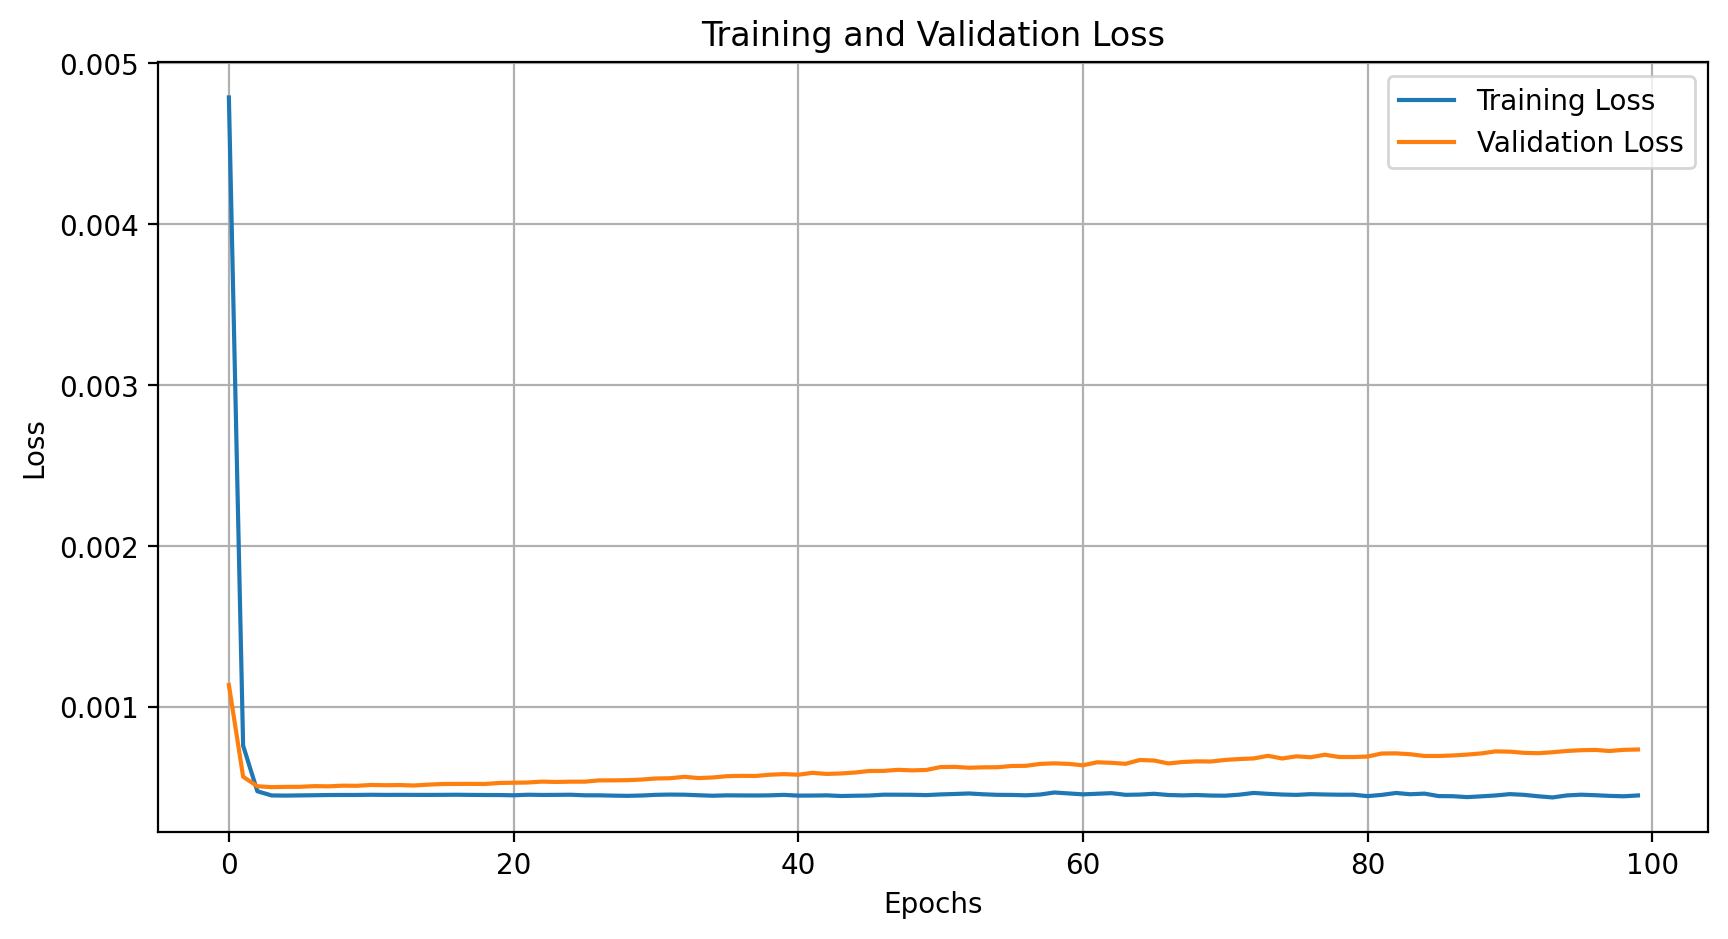

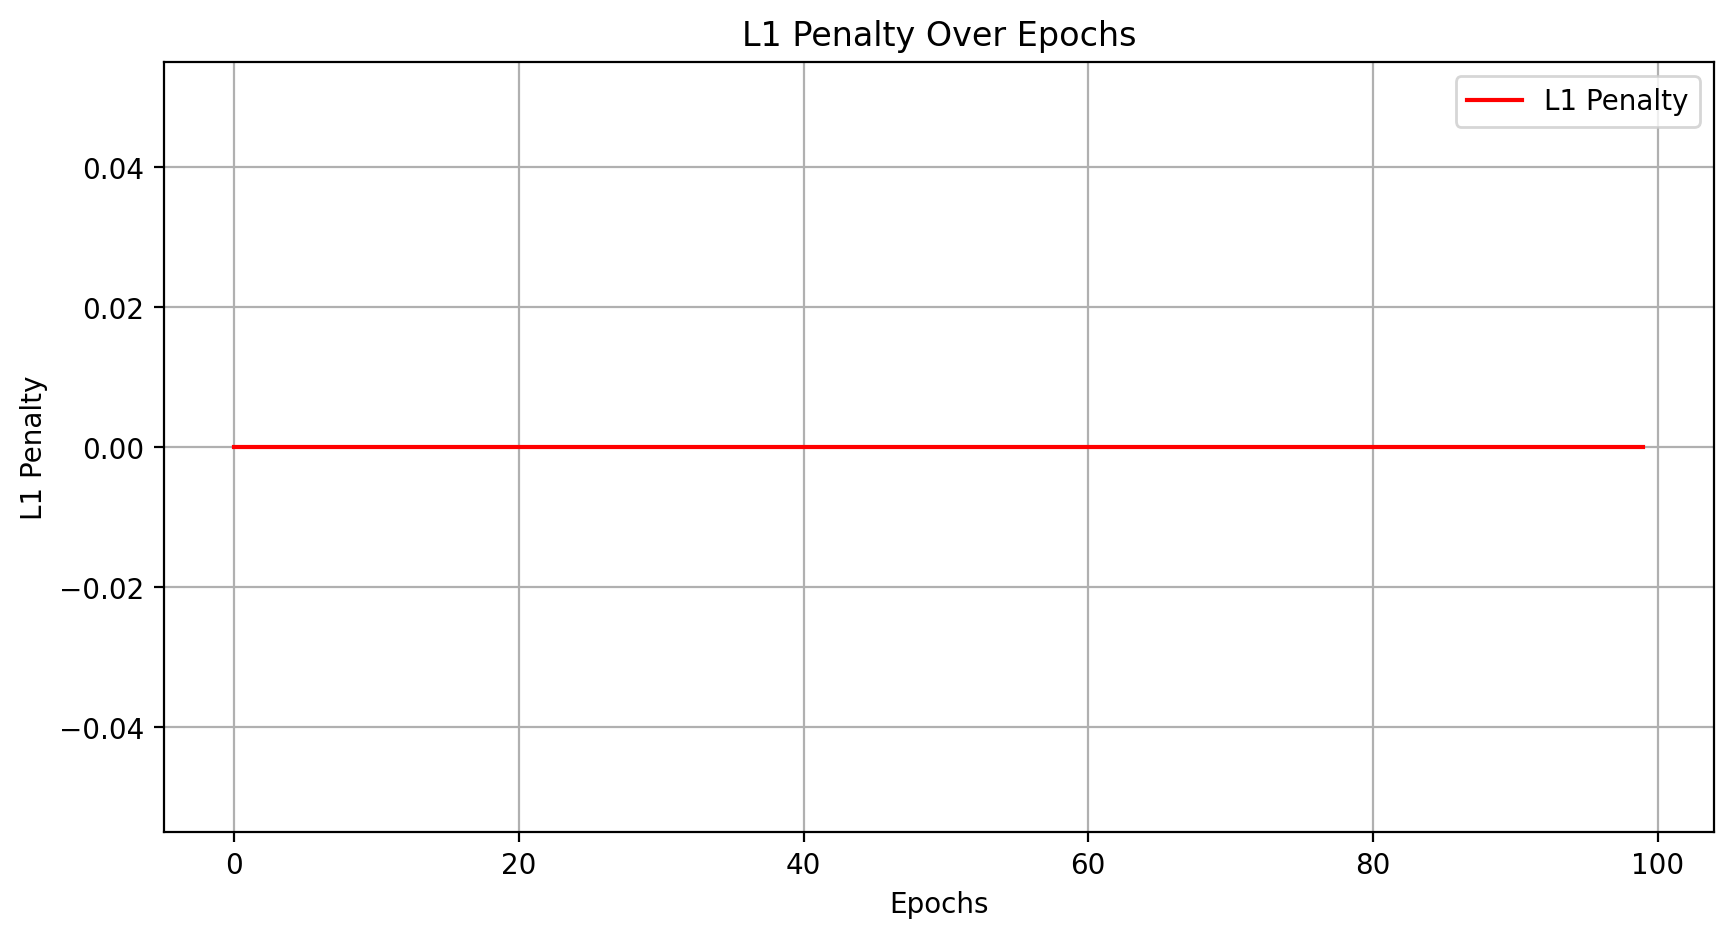

In [19]:
# full rank + gradient descent + initialize from closed form solution
# Example dimensions and settings
num_lags = 4
batch_size = 1000
train_start = 5
normalize = 1000
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate random data for demonstration
X = torch.Tensor(y_session_interp[train_start:,:]/normalize).to(device)
U = torch.Tensor(u_session[train_start:,:]).to(device)
state_dim = X.shape[1]
input_dim = U.shape[1]

# Create the dataset and dataloader
dataset = TimeseriesDataset(X, U, num_lags)

# Split the dataset using the train_data_index and considering the num_lags
train_subset, val_subset = split_dataset(dataset, train_indices[train_start:], num_lags)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = LinearDynamicModel(state_dim, input_dim, num_lags, init_value)

# Train the model
train_model(model, train_loader, val_loader, epochs = epochs, lr = 0.001, l1_lambda = 0.0)

In [20]:
# Load the best model checkpoint
checkpoint_path = 'checkpoints/model_best_test.pt'  # Update the path and filename as needed
model.load_state_dict(torch.load(checkpoint_path))
model.eval()  # Set the model to evaluation mode

Ahat_list = []
Ahat_list.insert(0, np.expand_dims(to_np(model.V), axis = 1))
for Bk, betak in zip(model.B, model.beta):
    Ahat_list.insert(0, to_np(singular_value_norm(Bk + torch.diag(betak))))
for Wk, alphak in zip(model.W, model.alpha):
    Ahat_list.insert(0, to_np(singular_value_norm(Wk + torch.diag(alphak))))
Ahat_gd = np.concatenate(Ahat_list, axis = 1)

In [21]:
# linear model + gradient descent + full rank + test set
x_pred = []
x_true = []
u_true = []
r2 = [] 
idx = -1
ark_order = 4
normalize = 1000
new_segment = True
segment_pred = []
segment_start = -1
for t in range(train_indices.shape[0]):
    if test_indices[t] == 1:
        if new_segment:
            segment_pred = []
            new_segment = False
            segment_start = t
            x_past = []
            x_pred.append([])
            x_true.append([])
            u_true.append([])
            idx += 1
        if t < segment_start + ark_order:
            x_past.append(y_session_interp[t,:].copy().flatten()/normalize)
        else:
            z = np.array(x_past).flatten()
            z = np.concatenate((z,u_session[t-ark_order:t,:].copy().flatten(),np.ones(1)))
            x_next = Ahat_gd @ z
            x_past.pop(0)
            x_past.append(x_next.copy())
            x_pred[idx].append(x_next.copy())
            x_true[idx].append(y_session_interp[t,:].copy().flatten()/normalize)
            u_true[idx].append(u_session[t,:].copy().flatten())
    else:
        new_segment = True

mse_losses = []
for i in range(len(x_pred)):
    x_pred[i] = np.array(x_pred[i])
    x_true[i] = np.array(x_true[i])
    u_true[i] = np.array(u_true[i])
    mse_losses.append((np.square(x_pred[i] - x_true[i])).mean())
    r2.append(r2_score(x_true[i], x_pred[i]))
print('mse:', sum(mse_losses)/len(mse_losses))

mse: 0.0007491437137739232


Text(0.5, 1.0, 'Input')

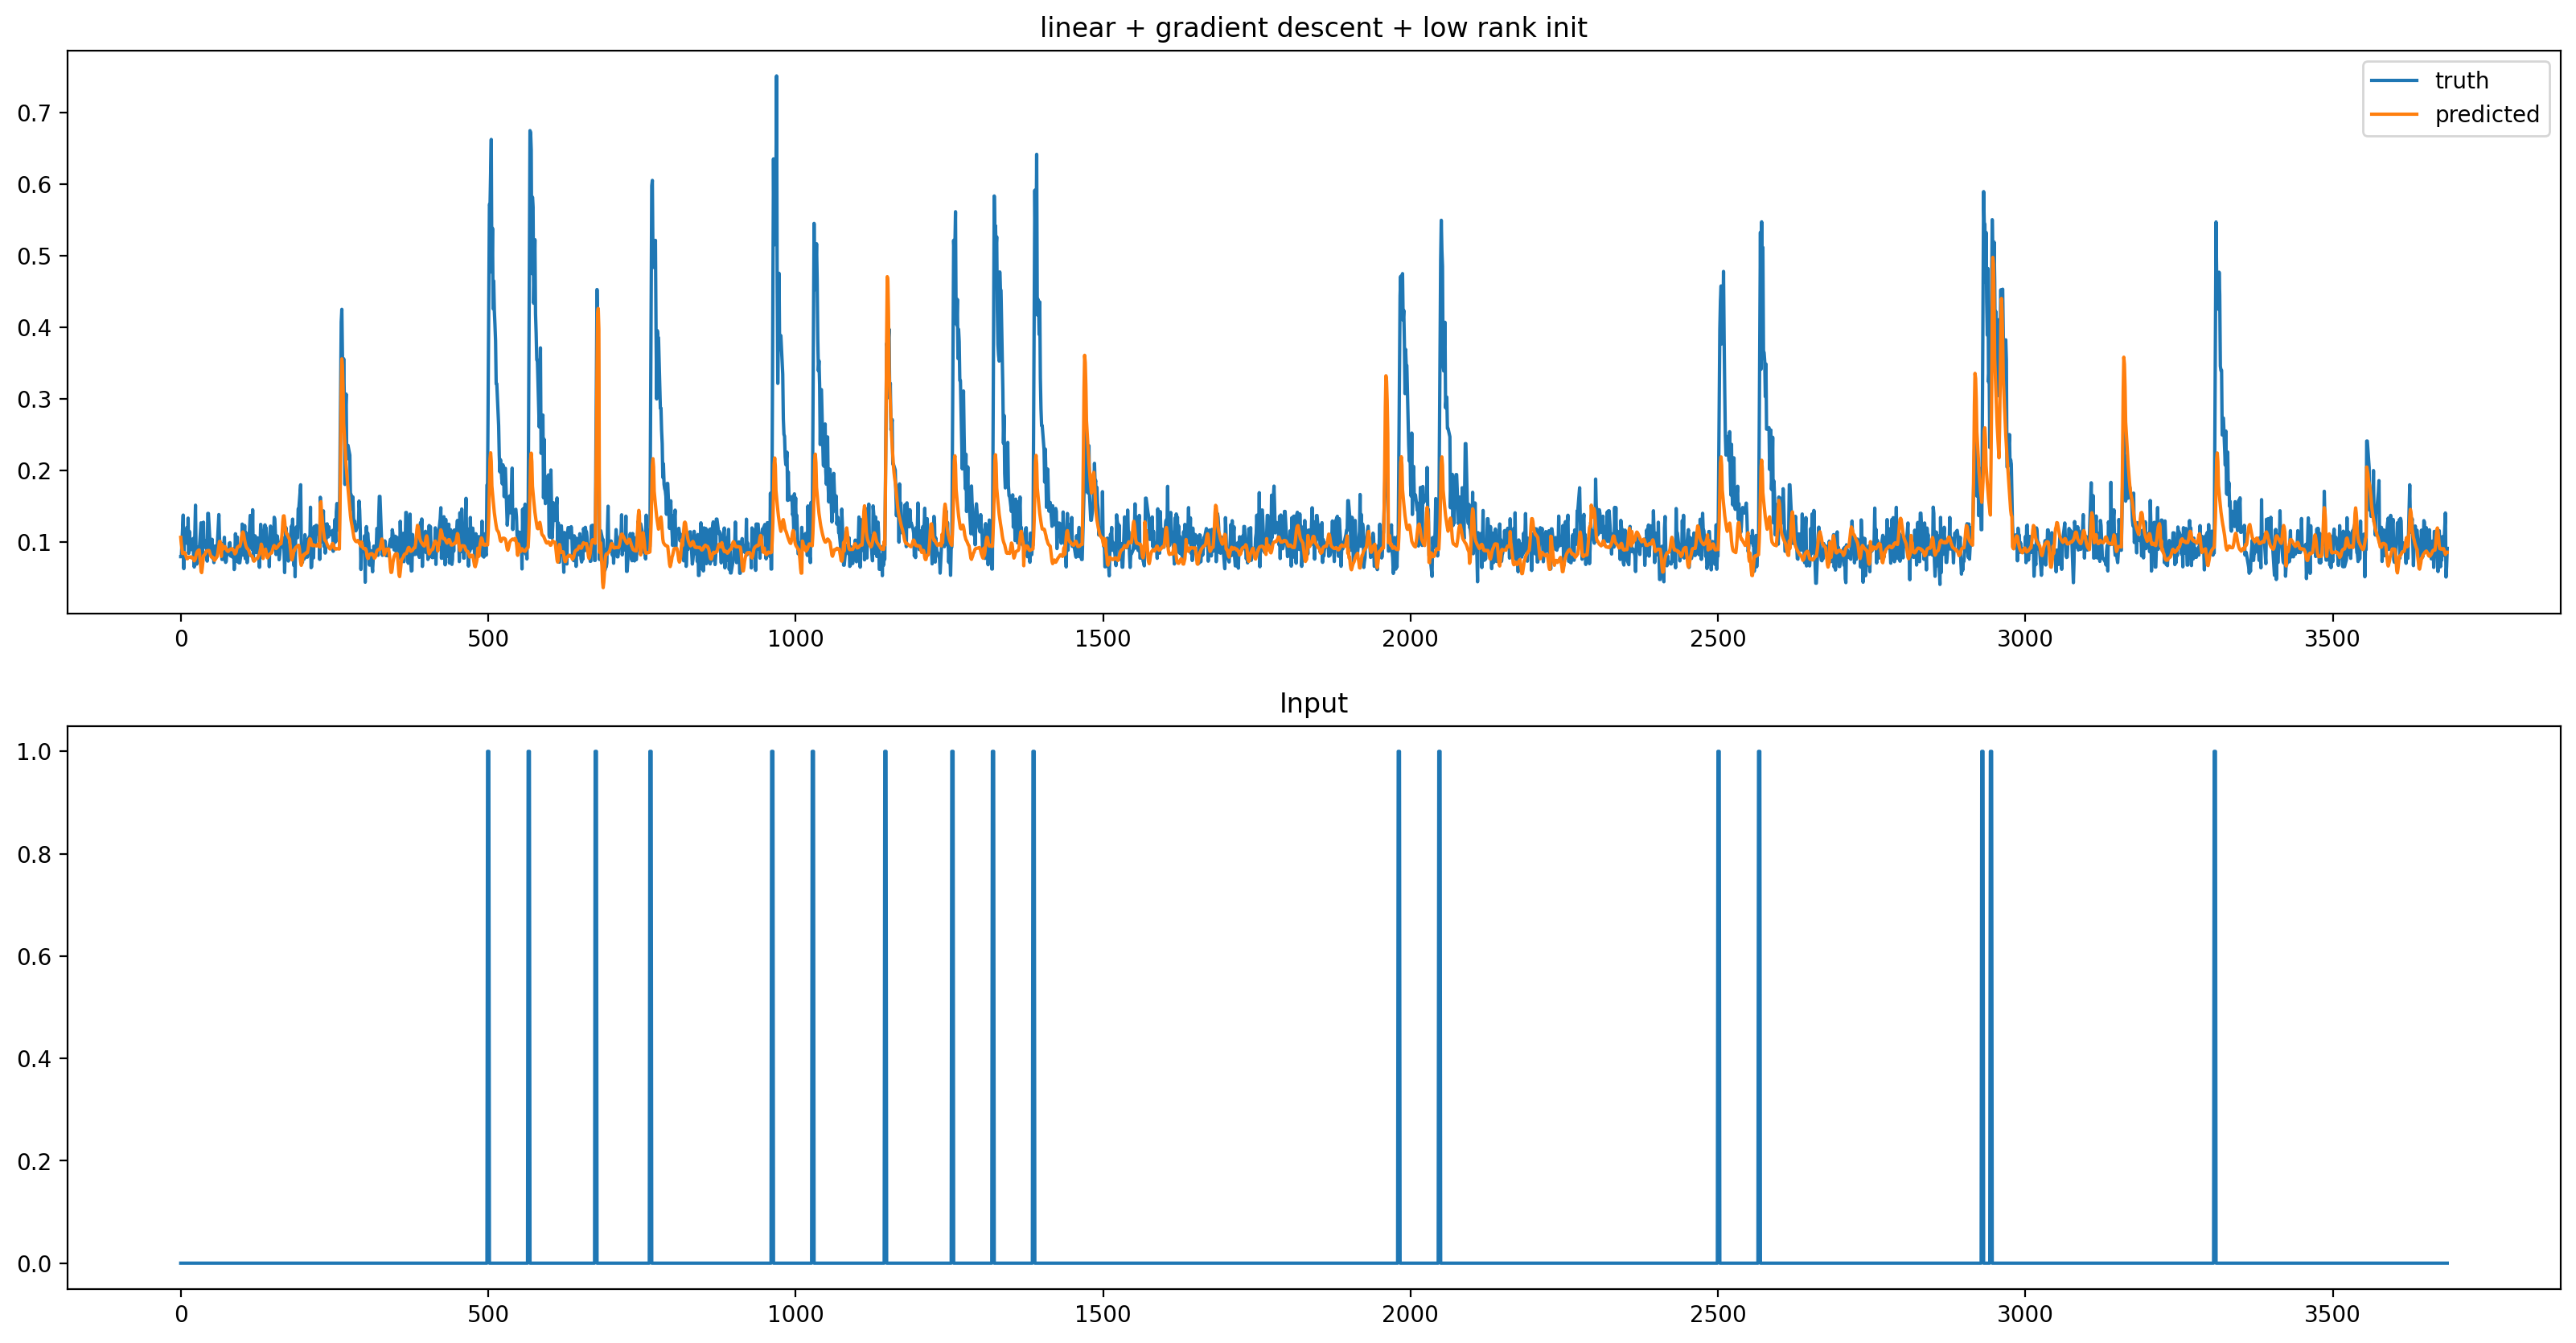

In [22]:
# linear model + gd + full rank init
neuron = removed_neurons[8]
length = 50
t_start = 30

output_pred = []
output_true = []
input_true = []
segment_marker = []

for i in range(t_start, t_start + np.min([len(x_true),length])):
    output_pred.extend(x_pred[i][:,neuron])
    #output_pred.append(np.nan)
    output_true.extend(x_true[i][:,neuron])
    #output_true.append(np.nan)
    input_true.extend(u_true[i][:,neuron])
    #input_true.append(np.nan)
    segment_marker.extend(np.nan*np.zeros(len(x_pred[i][:,neuron])-1))
    segment_marker.extend([0.25,0])
    
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(output_true,label='truth')
plt.plot(output_pred,label='predicted')
#plt.plot(segment_marker)
plt.title('linear + gradient descent + low rank init')
plt.legend()

plt.subplot(2,1,2)
plt.plot(input_true,label='input')
plt.title('Input')

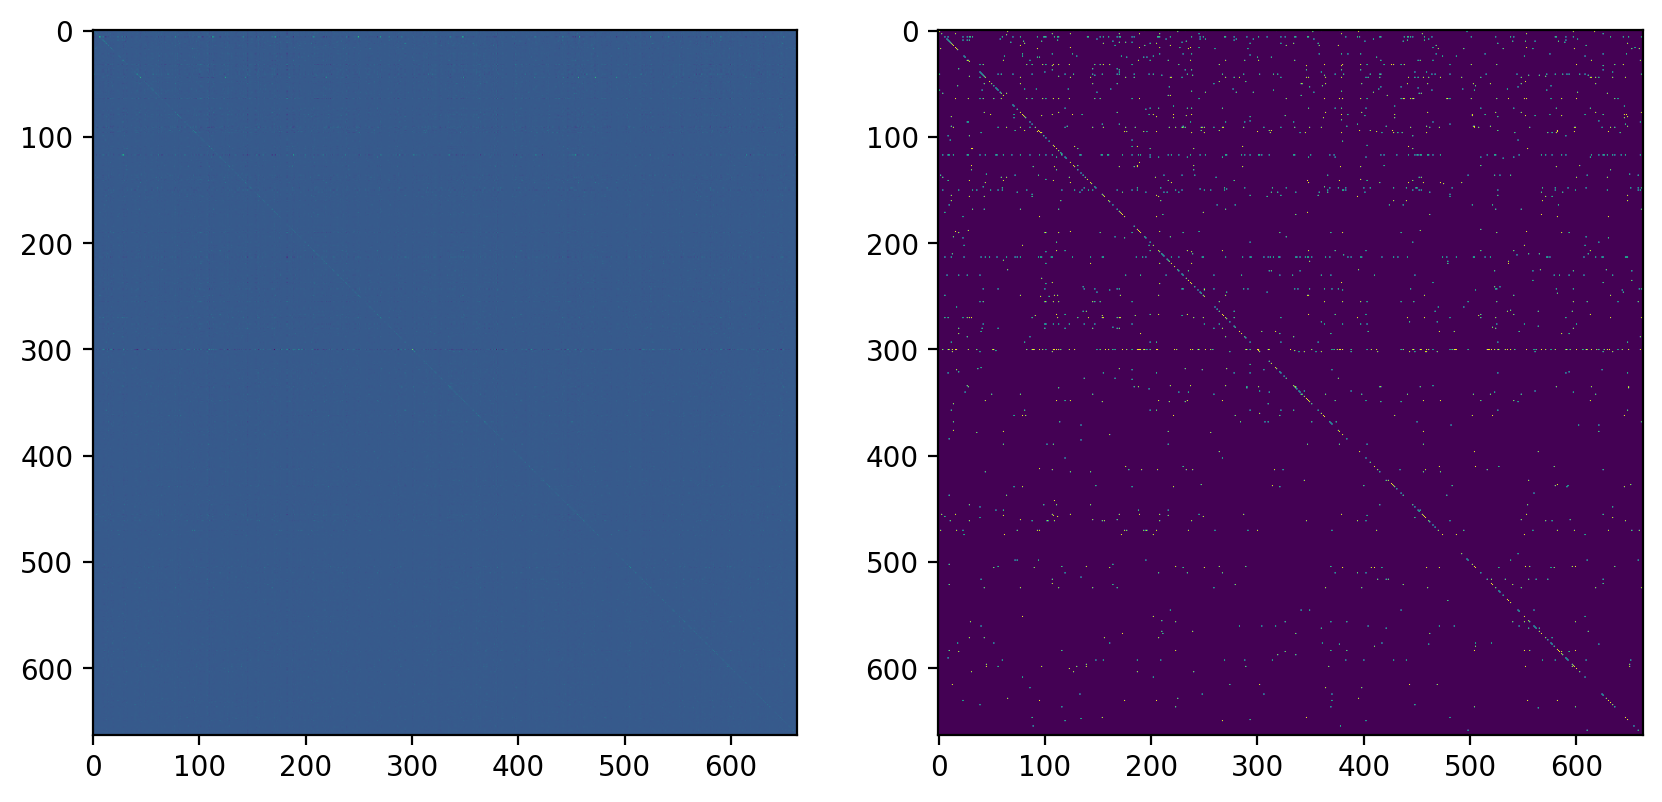

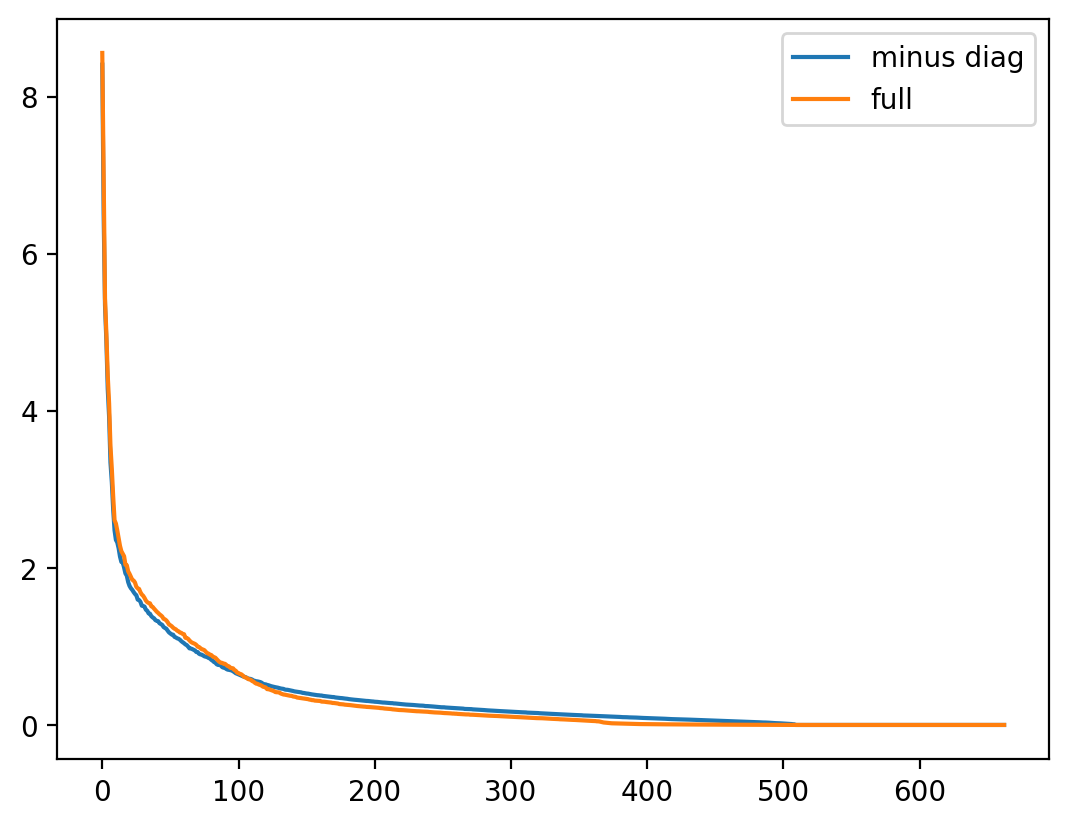

In [23]:
# solution from gradient descent
num_neurons = 663
d = num_neurons
A = compute_transfer_matrix(Ahat_gd)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(A)

connection_threshold = 1*np.mean(np.diag(A))
A_threshold = (A > connection_threshold).astype(float)
plt.subplot(1,2,2)
plt.imshow(A > connection_threshold)
# plt.imshow(A > connection_threshold, norm=colors.Normalize(vmin=0,vmax=0.5))
plt.figure()
plot_rank_svd(A)

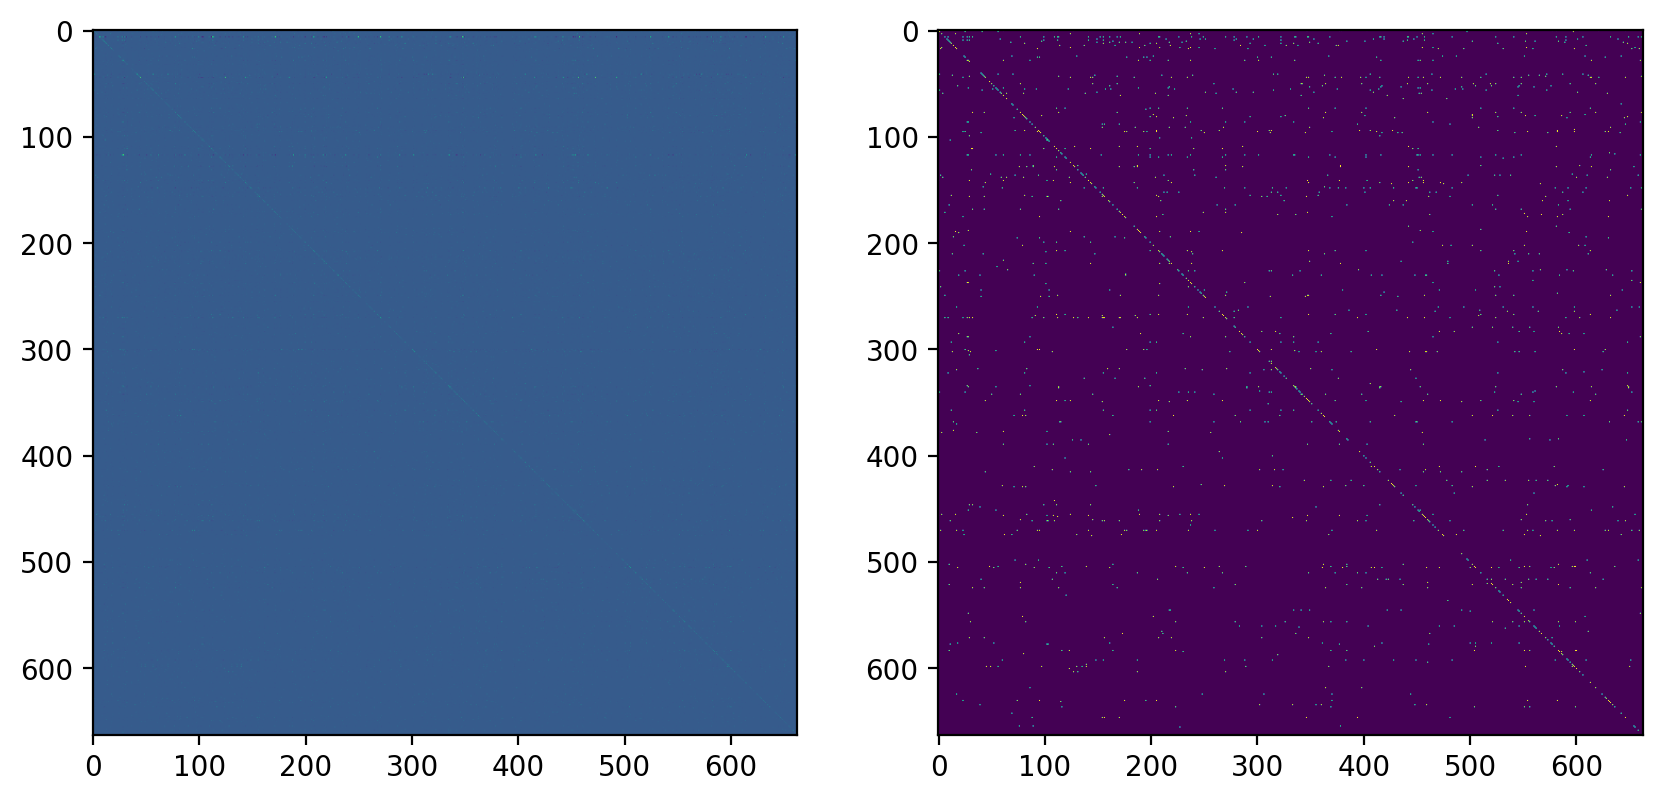

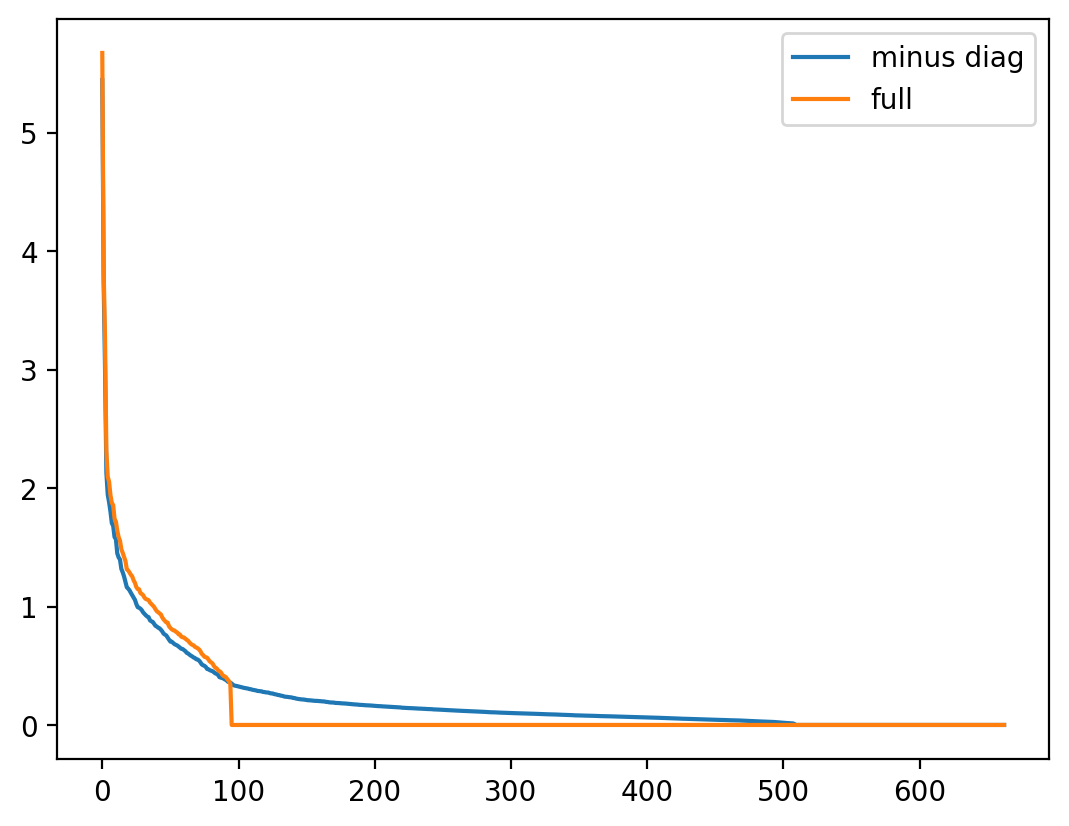

In [24]:
# solution from closed form
num_neurons = 663
d = num_neurons
A = compute_transfer_matrix(Ahat)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(A)

connection_threshold = 1*np.mean(np.diag(A))
A_threshold = (A > connection_threshold).astype(float)
plt.subplot(1,2,2)
plt.imshow(A > connection_threshold)
# plt.imshow(A > connection_threshold, norm=colors.Normalize(vmin=0,vmax=0.5))
plt.figure()
plot_rank_svd(A)